# SAving all model chechkpoints for each epoch

Using device: cuda
Model: gpt2, Parameters: 124.44M
Train size: 25000, Val size: 5000
Sample train: {'text': 'Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW 

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Starting training...


wandb: Currently logged in as: soham-petkar (soham-petkar-plaksha) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.771500,2.783678
2,2.770300,2.757700


Training completed.


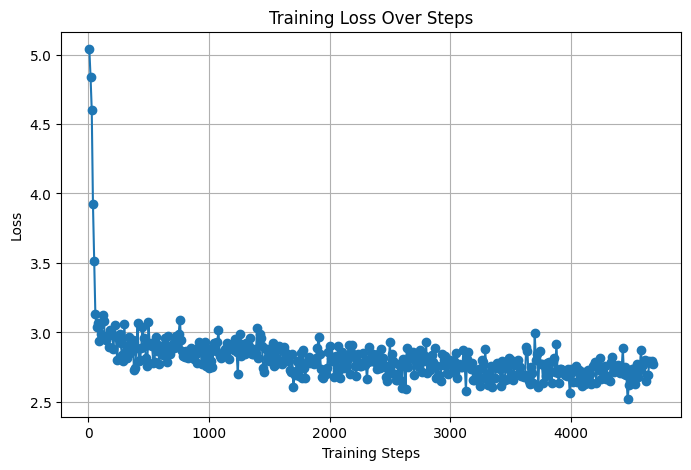

In [1]:
# Cell 1: Install required libraries (run once if not installed)
# !pip install transformers datasets torch matplotlib tqdm

# Cell 2: Import libraries and set device
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cell 3: Load GPT-2 model and tokenizer
model_name = "gpt2"  # GPT-2 small (124M parameters)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model and set pad_token_id, then move to device
model = AutoModelForCausalLM.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.pad_token_id
model = model.to(device)

print(f"Model: {model_name}, Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")

# Cell 4: Load and preprocess the IMDb dataset
dataset = load_dataset("imdb")

def format_imdb_example(example):
    label_map = {0: "negative", 1: "positive"}
    prompt = f"Review: {example['text']} Sentiment: {label_map[example['label']]}"
    return {"text": prompt, "label": example["label"]}

train_dataset = dataset["train"].map(format_imdb_example)
val_dataset = dataset["test"].map(format_imdb_example)
# Use only the first 5000 examples from validation for faster evaluation
val_dataset = val_dataset.select(range(5000))
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
print("Sample train:", train_dataset[0])
print("Sample val:", val_dataset[0])

# Cell 5: Tokenize the dataset
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    # For causal LM, labels are the same as input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()
    # Retain sentiment label (though not used in training here)
    tokenized["sentiment_labels"] = examples["label"]
    return tokenized

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Set format for PyTorch tensors
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels", "sentiment_labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels", "sentiment_labels"])

# Optional: Save tokenized datasets to disk for later use
tokenized_train.save_to_disk("tokenized_train")
tokenized_val.save_to_disk("tokenized_val")

# Cell 6: Set up training arguments to save model checkpoints after every epoch
training_args = TrainingArguments(
    output_dir="./results",             # Directory to store checkpoints
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",              # Save model checkpoint at the end of each epoch
    load_best_model_at_end=False,       # We're saving every checkpoint, no need for best model selection here
    push_to_hub=False,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=4
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

# Cell 7: Train the model and save checkpoints
print("Starting training...")
train_result = trainer.train()
trainer.save_model()  # Save the final model as well
print("Training completed.")

# Cell 8: Plot the training loss graph
# Trainer logs are stored in trainer.state.log_history as a list of dicts
log_history = trainer.state.log_history
# Extract only the entries with a loss value
loss_entries = [entry for entry in log_history if "loss" in entry]
steps = [entry["step"] for entry in loss_entries]
losses = [entry["loss"] for entry in loss_entries]

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.show()

# Note:
# The saved checkpoints will be in the "./results" directory, e.g.:
# ./results/checkpoint-<step_number>
# For 3 epochs, you should see 3 checkpoint folders containing the model weights.


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Step 1: Load IMDb Test Dataset
# -----------------------------
test_dataset = load_dataset("imdb", split="test")
sample_size = 200  # Adjust as needed
test_subset = test_dataset.select(range(sample_size))

# -----------------------------
# Step 2: Load Tokenizer
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# -----------------------------
# Step 3: Define Classification Function with Truncation
# -----------------------------
def classify_review(model, tokenizer, review_text):
    """
    Create a prompt from review text and return 1 if the logit for " positive"
    is higher than for " negative", otherwise return 0.
    We set truncation and a max_length to ensure the input doesn't exceed 1024 tokens.
    """
    prompt = f"Review: {review_text} Sentiment:"
    # Use truncation and set max_length to 1024 to avoid over-length issues.
    input_ids = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids)
    # Get logits for the token immediately after the prompt
    logits = outputs.logits[0, -1, :]  # shape: (vocab_size,)
    
    # Get candidate token ids for " positive" and " negative" (with a leading space)
    pos_ids = tokenizer.encode(" positive", add_special_tokens=False)
    neg_ids = tokenizer.encode(" negative", add_special_tokens=False)
    
    vocab_size = logits.size(0)
    pos_log_prob = logits[pos_ids[0]].item() if pos_ids and pos_ids[0] < vocab_size else float("-inf")
    neg_log_prob = logits[neg_ids[0]].item() if neg_ids and neg_ids[0] < vocab_size else float("-inf")
    
    return 1 if pos_log_prob > neg_log_prob else 0

# -----------------------------
# Step 4: Define Evaluation Function
# -----------------------------
def evaluate_model(model, tokenizer, dataset):
    correct = 0
    total = 0
    for example in tqdm.tqdm(dataset, desc="Evaluating"):
        review_text = example["text"]
        true_label = example["label"]  # 0 for negative, 1 for positive
        try:
            pred_label = classify_review(model, tokenizer, review_text)
        except Exception as e:
            print("Error processing review; defaulting to label 0:", e)
            pred_label = 0
        correct += int(pred_label == true_label)
        total += 1
    return correct / total if total > 0 else 0

# -----------------------------
# Step 5: Evaluate Base Model
# -----------------------------
print("Evaluating Base Model...")
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
base_model.config.pad_token_id = base_model.config.eos_token_id
base_model.to(device)
base_model.eval()

base_accuracy = evaluate_model(base_model, tokenizer, test_subset)
print(f"Base Model Accuracy: {base_accuracy * 100:.2f}%")

# Clear base model from GPU memory
del base_model
torch.cuda.empty_cache()

# -----------------------------
# Step 6: Evaluate Finetuned Model
# -----------------------------
print("Evaluating Finetuned Model...")
# Update finetuned_model_path to your checkpoint directory.
finetuned_model_path = "./results/checkpoint-3126"  
finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path)
finetuned_model.config.pad_token_id = finetuned_model.config.eos_token_id
finetuned_model.to(device)
finetuned_model.eval()

finetuned_accuracy = evaluate_model(finetuned_model, tokenizer, test_subset)
print(f"Finetuned Model Accuracy: {finetuned_accuracy * 100:.2f}%")

# Clear finetuned model from GPU memory
del finetuned_model
torch.cuda.empty_cache()


Using device: cuda


Evaluating Base Model...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.25it/s]


Base Model Accuracy: 45.50%
Evaluating Finetuned Model...


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.64it/s]


Finetuned Model Accuracy: 96.00%


In [3]:
dataset = load_dataset("imdb", split="test")

def filter_by_label(data, label, max_samples=100):
    filtered = [d for d in data if d["label"] == label]
    return filtered[:max_samples]

pos_samples = filter_by_label(dataset, 1, max_samples=100)
neg_samples = filter_by_label(dataset, 0, max_samples=100)

print(f"Positive samples: {len(pos_samples)}, Negative samples: {len(neg_samples)}")

# If you want fewer or more samples, adjust max_samples above.


Positive samples: 100, Negative samples: 100


In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def encode_reviews(samples):
    texts = [s["text"] for s in samples]
    toks = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        max_length=1024,
        padding="max_length"
    )
    return toks["input_ids"], toks["attention_mask"]

pos_input_ids, pos_mask = encode_reviews(pos_samples)
neg_input_ids, neg_mask = encode_reviews(neg_samples)

pos_input_ids, pos_mask = pos_input_ids.to(device), pos_mask.to(device)
neg_input_ids, neg_mask = neg_input_ids.to(device), neg_mask.to(device)


In [5]:
def get_last_token_activations(model, input_ids, attention_mask, batch_size=8):
    """
    Returns a numpy array of shape (num_samples, hidden_dim)
    containing the last hidden-state vectors for each sequence.
    """
    model.eval()
    all_acts = []
    ds = TensorDataset(input_ids, attention_mask)
    dl = DataLoader(ds, batch_size=batch_size)
    
    with torch.no_grad():
        for ids_batch, mask_batch in tqdm.tqdm(dl, desc="Extracting activations"):
            outputs = model(
                ids_batch,
                attention_mask=mask_batch,
                output_hidden_states=True,
                return_dict=True
            )
            # The final hidden state is outputs.hidden_states[-1]
            # shape: (batch_size, seq_len, hidden_dim)
            final_hidden = outputs.hidden_states[-1]
            
            # Extract the last token from each sequence
            last_token_act = []
            for seq_i, mask in zip(final_hidden, mask_batch):
                # find the last non-padding token
                last_nonpad_idx = (mask == 1).nonzero()[-1].item()
                last_token_act.append(seq_i[last_nonpad_idx].unsqueeze(0))
            last_token_act = torch.cat(last_token_act, dim=0)  # shape: (batch_size, hidden_dim)
            
            all_acts.append(last_token_act.cpu())
    return torch.cat(all_acts, dim=0).numpy()


In [9]:
from torch.utils.data import DataLoader, TensorDataset

model_paths = {
    "base": "gpt2",
    "finetuned": "./results/checkpoint-3126"  # update to your actual checkpoint path
}

all_activations = {}  # {model_label: (pos_acts, neg_acts)}

for label, path in model_paths.items():
    print(f"\nCollecting activations for {label} model...")
    model = AutoModelForCausalLM.from_pretrained(path)
    model.config.pad_token_id = tokenizer.pad_token_id
    model.to(device)
    model.eval()
    
    # Extract last-token activations for positive and negative sets
    pos_acts = get_last_token_activations(model, pos_input_ids, pos_mask, batch_size=8)
    neg_acts = get_last_token_activations(model, neg_input_ids, neg_mask, batch_size=8)
    
    all_activations[label] = (pos_acts, neg_acts)
    
    # Clear model from GPU to save memory if analyzing multiple models
    del model
    torch.cuda.empty_cache()


Extracting activations:   0%|          | 0/13 [00:00<?, ?it/s]

Extracting activations: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Extracting activations: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]



Running t-SNE for base model... (this can be slow)



Running t-SNE for finetuned model... (this can be slow)


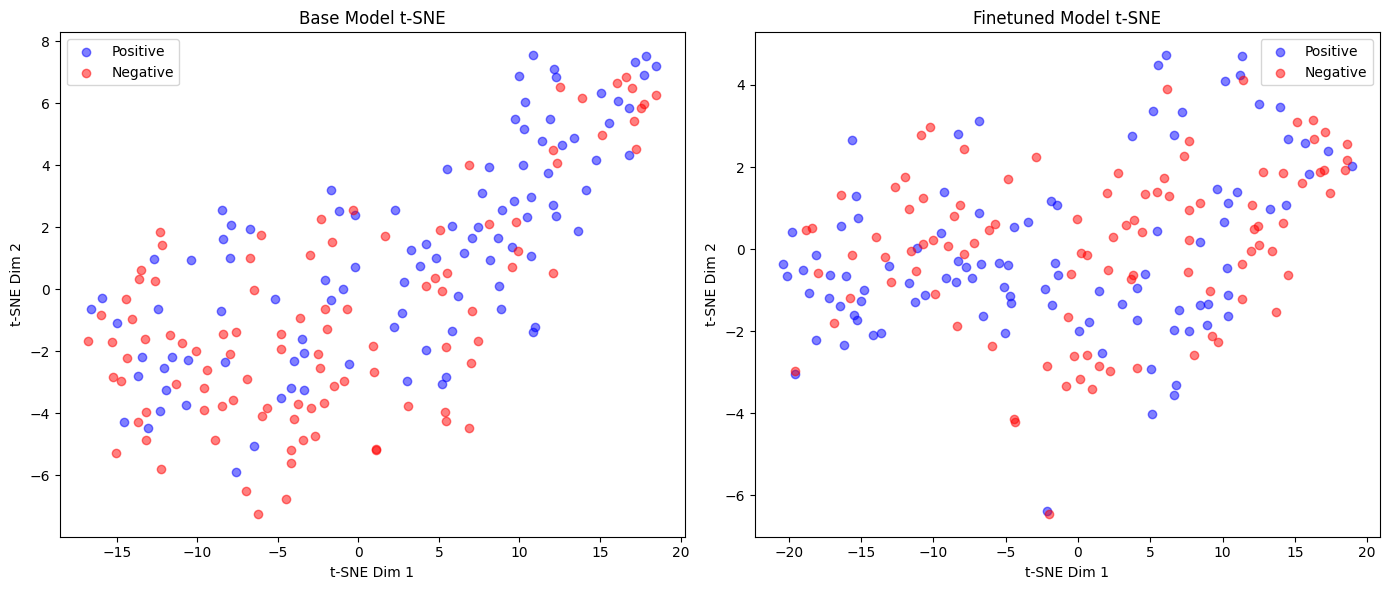

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

model_labels = list(all_activations.keys())
for i, label in enumerate(model_labels):
    ax = axs[i]
    
    pos_acts, neg_acts = all_activations[label]
    all_acts = np.concatenate([pos_acts, neg_acts], axis=0)
    
    # Run t-SNE
    print(f"\nRunning t-SNE for {label} model... (this can be slow)")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca")
    tsne_acts = tsne.fit_transform(all_acts)
    
    # Split back into pos vs neg
    pos_count = len(pos_acts)
    pos_tsne = tsne_acts[:pos_count]
    neg_tsne = tsne_acts[pos_count:]
    
    ax.scatter(pos_tsne[:, 0], pos_tsne[:, 1], c='blue', alpha=0.5, label='Positive')
    ax.scatter(neg_tsne[:, 0], neg_tsne[:, 1], c='red', alpha=0.5, label='Negative')
    ax.set_title(f"{label.capitalize()} Model t-SNE")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")
    ax.legend()

plt.tight_layout()
plt.show()
